# Figure 5
Comparison of ATL03-provided photon confidences/densities and FLUID signal confidence / SNR estimates.

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from fig5code import *

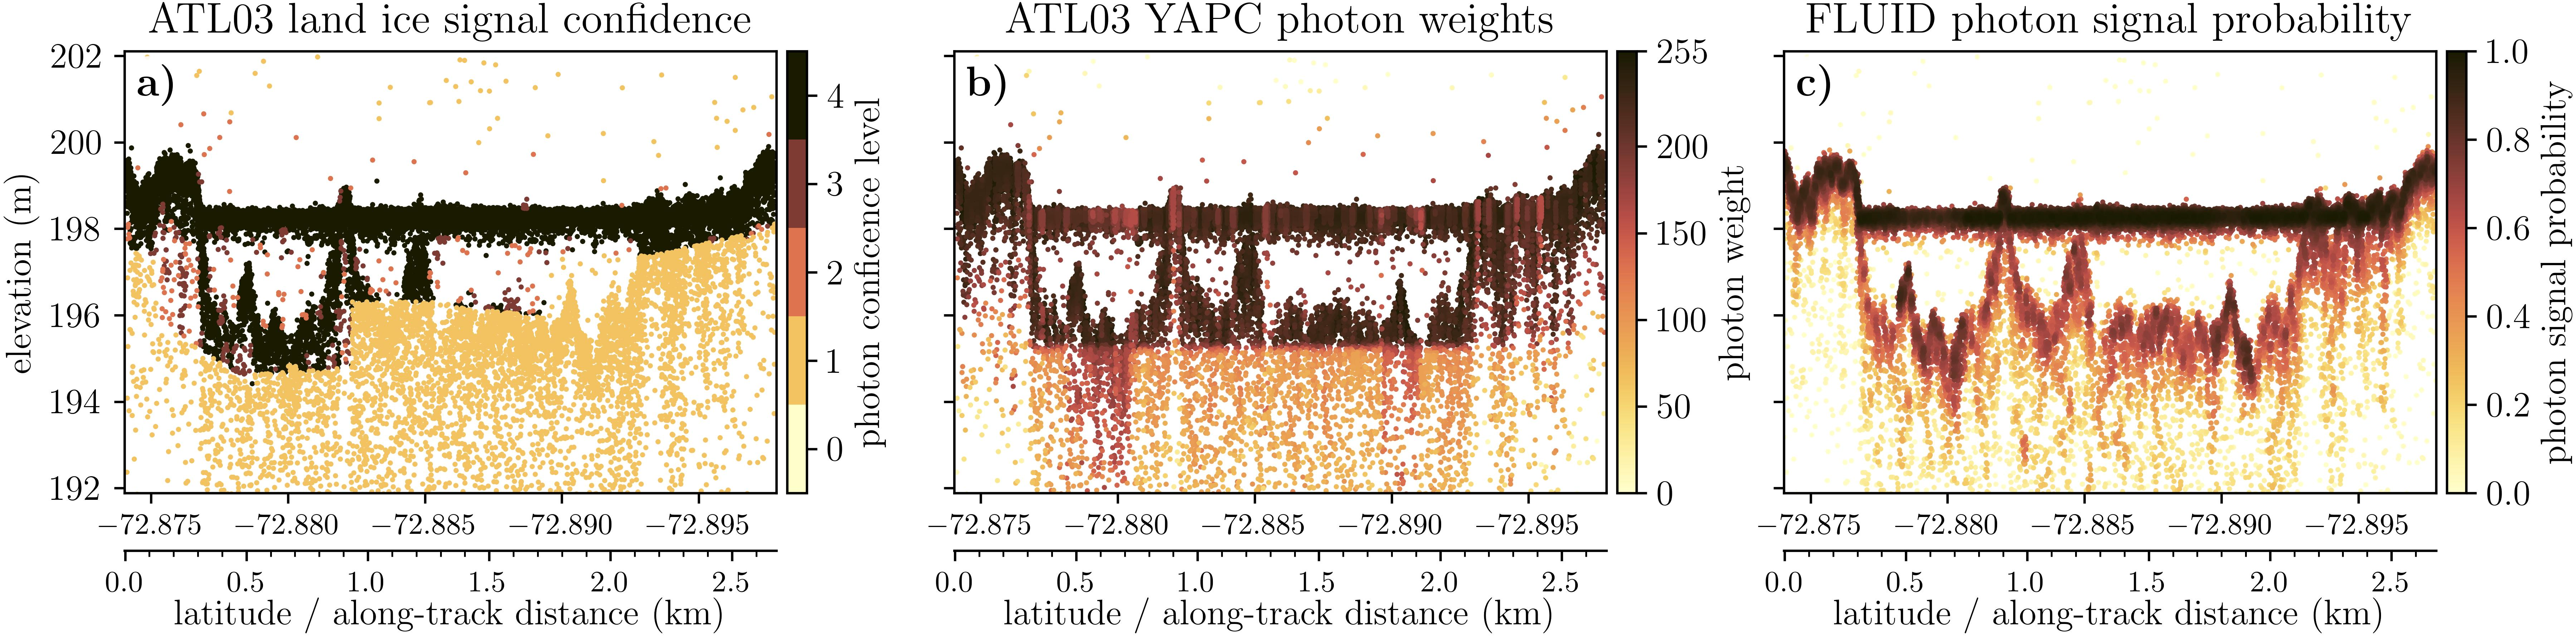


LAKE INFO: 
  granule_id:            ATL03_20190102184312_00810210_006_02.h5
  RGT:                   81
  GTX:                   GT2L
  beam:                  3 (strong)
  acquisition time:      2019-01-02T18:49:15Z
  center location:       (67.30820E, 72.88593S)
  ice sheet:             AIS
  melt season:           2018-19



In [2]:
# input data
file_name_lake = 'data/lake_density_example.h5'
plotname = '../figures/fig05-density_comparison.jpg'

# some figure settings
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
cmap_fig = cmc.lajolla
scattersize = 3

# read in the melt lake data
lk = dictobj(read_melt_lake_h5(file_name_lake))
df = lk.photon_data
surf_elev = lk.surface_elevation
gtx = lk.gtx
ylms = np.array((-2.5*lk.max_depth, 1.5*lk.max_depth)) + surf_elev
xlms = (df.lat.min(), df.lat.max())

# can re-run density estimation to explore results for different parameters 
# (will change directly in file, make copy first to save original data)
# df = get_density(file_name_lake, segment_length=140, signal_width=0.3, aspect=30, K_phot=15, h_signal=surf_elev, frac_noise=0.05)

# download ATL03 data from NSIDC (if they're not already there), and read in the data (for ATL03 confidence and YAPC values)
fn_atl03 = download_full_atl03_for_lake(lk)
beams_available, ancillary, dfs = read_atl03(fn_atl03, geoid_h=True, gtxs_to_read=gtx)
df03 = dfs[gtx]

# make the figure
fig, axs = plt.subplots(figsize=[12, 3], dpi=100, nrows=1, ncols=3, sharey=True)

# plot the ATL03 land-ice confidences
ax = axs[0]
df_conf = df03.sort_values(by='conf', ascending=False)
n_bins = 5
colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
scatt = ax.scatter(df_conf.lat, df_conf.h, s=scattersize, alpha=1, c=df_conf.conf, cmap=thecmap, vmin=-0.5, vmax=4.5, edgecolors='none')
ax.set_title('ATL03 land ice signal confidence')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
cbar.set_label('photon conficence level', labelpad=3)
ax.set_ylabel('elevation (m)')

# plot the YAPC photon weights
ax = axs[1]
df_yapc = df03.sort_values(by='weight_ph', ascending=False)
n_bins = 255
colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
scatt = ax.scatter(df_yapc.lat, df_yapc.h, s=scattersize, alpha=1, c=df_yapc.weight_ph, cmap=thecmap, vmin=0, vmax=255, edgecolors='none')
ax.set_title('ATL03 YAPC photon weights')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical', ticks=[0, 50, 100, 150, 200, 255])
cbar.set_label('photon weight', labelpad=3)

# plot the FLUID signal confidence
ax = axs[2]
dfp = df[~df.is_afterpulse].copy() # afterpulses are removed before snr estimation - their snr is set to zero
n_bins = 1000
colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
dfp.snr /= dfp.snr.max()
scatt = ax.scatter(dfp.lat, dfp.h, s=scattersize, alpha=1, c=dfp.snr, cmap=thecmap, vmin=0, vmax=1, edgecolors='none')
ax.set_title('FLUID photon signal probability')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
cbar.set_label('photon signal probability', labelpad=3)

# apply the same x/y limits to axes and format labels
for ax in axs.flatten():
    ax.set_xlim(xlms)
    ax.set_ylim(ylms)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.tick_params(axis='x', labelsize=10)

# get ground track for lat-xatc conversion
df['x10'] = np.round(df.xatc, -1)
gt = df.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()

# flip x-axis if track is descending, to make along-track distance go from left to right
if gt.lat.iloc[0] > gt.lat.iloc[-1]:
    for axx in axs.flatten():
        axx.set_xlim(np.flip(np.array(xlms)))

# add along-track distance
lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat']].reset_index(drop=True)
_lat = np.array(lx.lat)
_xatc = np.array(lx.x10) / 1e3
def lat2xatc(l):
    return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
def xatc2lat(x):
    return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
for ax in axs.flatten():
    secax = ax.secondary_xaxis(-0.13, functions=(lat2xatc, xatc2lat))
    secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    secax.set_xlabel('latitude / along-track distance (km)',labelpad=0)
    secax.tick_params(axis='both', which='major', labelsize=10)
    secax.ticklabel_format(useOffset=False, style='plain')

# add panel labels
for j, ax in enumerate(axs.flatten()):
    ax.text(0.02, 0.97, r'\textbf{%s)}' % chr(ord('a') + j), transform=ax.transAxes, ha='left', va='top', fontsize=14,
           bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=.2,rounding_size=0.5', lw=0))

fig.tight_layout(pad=0.1, h_pad=0.3)

# save file
fig.savefig(plotname, dpi=600)
plt.close(fig)

# show plot and print info
display(Image(plotname))
print_lake_info(file_name_lake, print_imagery_info=False)